# 3

## 3.0 Introduction

These are the data cleaning steps that I'll need to do for the final project, so I took the opportunity to do them. You may skip this while grading.

Note: all of these steps were for homework 3, re-used for the final project. I've omitted cells at the end that were not relevant to the final project.

In [1]:
import arviz as az
import jax
import numpy as np
import numpyro
import polars as pl
from jax import numpy as jnp
from numpyro import distributions as dist
from numpyro.infer import MCMC, NUTS
from sklearn.preprocessing import OrdinalEncoder

numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

In [28]:
crss_vehicle = pl.read_csv(
    "/Users/mcanearm/Projects/road_fatilities/data/CRSS2022CSV/vpicdecode.csv",
    ignore_errors=True,
)
fars_vehicle = pl.read_csv(
    "/Users/mcanearm/Projects/road_fatilities/data/FARS2022NationalCSV/vpicdecode.csv",
    ignore_errors=True,
)
crss_accidents = pl.read_csv(
    "/Users/mcanearm/Projects/road_fatilities/data/CRSS2022CSV/accident.csv",
    ignore_errors=True,
)
fars_accidents = pl.read_csv(
    "/Users/mcanearm/Projects/road_fatilities/data/FARS2022NationalCSV/accident.csv",
    ignore_errors=True,
)
crss_pb = pl.read_csv(
    "/Users/mcanearm/Projects/road_fatilities/data/CRSS2022CSV/pbtype.csv",
    ignore_errors=True,
)
fars_pb = pl.read_csv(
    "/Users/mcanearm/Projects/road_fatilities/data/FARS2022NationalCSV/pbtype.csv",
    ignore_errors=True,
)
crss_vehicle_speed = pl.read_csv(
    "/Users/mcanearm/Projects/road_fatilities/data/CRSS2022CSV/vehicle.csv",
    ignore_errors=True,
)
fars_vehicle_speed = pl.read_csv(
    "/Users/mcanearm/Projects/road_fatilities/data/FARS2022NationalCSV/vehicle.csv",
    ignore_errors=True,
)

In [29]:
crss_vehicle_speed["TRAV_SP"]

TRAV_SP
i64
998
998
70
45
0
…
998
998
998


We will implement a slightly new model. One of our research questions is "how much do environmental conditions influence the fatality rate of accidents."

To model this, we will consider the conditional distribution of fatalities under various scenarios. Here, we are doing some extra data cleaning in order to facilitate further analysis later.

In [32]:
fars_vehicle_df = fars_vehicle[
    [
        "ST_CASE",
        "VEH_NO",
        "VEHICLEDESCRIPTOR",
        "VEHICLETYPEID",
        "VEHICLETYPE",
        "MANUFACTURERFULLNAME",
        "MAKE",
        "MODEL",
        "MODELYEAR",
        "SERIES",
        "TRIM",
        "BASEPRICE",
        "BODYCLASSID",
        "BODYCLASS",
        "GROSSVEHICLEWEIGHTRATINGFROMID",
        "GROSSVEHICLEWEIGHTRATINGFROM",
        "GROSSCOMBWEIGHTRATINGFROMID",
        "GROSSCOMBWEIGHTRATINGFROM",
        "CURBWEIGHTLB",
        "SEATSCOUNT",
        "SEATROWSCOUNT",
        "DISPLACEMENTL",
        "PEDESTRIANAUTOEMERGENCYBRAKINGID",
        "PEDESTRIANAUTOEMERGENCYBRAKING",
        "BLINDSPOTWARNING",
        "BLINDSPOTINTERVENTION",
        "LANEDEPARTUREWARNING",
        "LANEKEEPINGASSISTANCE",
        "LANECENTERINGASSISTANCE",
        "BACKUPCAMERA",
        "REARCROSSTRAFFICALERT",
        "REARAUTOMATICEMERGENCYBRAKING",
        "DAYTIMERUNNINGLIGHT",
        "HEADLAMPLIGHTSOURCE",
        "SEMIAUTOHEADLAMPBEAMSWITCHING",
        "ADAPTIVEDRIVINGBEAM",
        "ADAPTIVECRUISECONTROL",
        "ANTILOCKBRAKESYSTEM",
        "ELECTRONICSTABILITYCONTROL",
        "TPMS",
        "AUTOMATICCRASHNOTIFICATION",
        "EVENTDATARECORDER",
        "TRACTIONCONTROL",
        "AUTOPEDESTRIANALERTINGSOUND",
        "ACTIVESAFETYSYSNOTE",
    ]
].join(fars_vehicle_speed[["ST_CASE", "VEH_NO", "TRAV_SP"]], on=["ST_CASE", "VEH_NO"])

crss_vehicle_df = crss_vehicle.select(
    pl.col(
        [
            "CASENUM",
            "VEH_NO",
            "VehicleDescriptor",
            "VehicleTypeId",
            "VehicleType",
            "ManufacturerFullName",
            "Make",
            "Model",
            "ModelYear",
            "Series",
            "Trim",
            "BasePrice",
            "BodyClassId",
            "BodyClass",
            "GrossVehicleWeightRatingFromId",
            "GrossVehicleWeightRatingFrom",
            "GrossCombWeightRatingFromId",
            "GrossCombWeightRatingFrom",
            "CurbWeightLB",
            "SeatsCount",
            "SeatRowsCount",
            "DisplacementL",
            "PedestrianAutoEmergencyBrakingId",
            "PedestrianAutoEmergencyBraking",
            "BlindSpotWarning",
            "BlindSpotIntervention",
            "LaneDepartureWarning",
            "LaneKeepingAssistance",
            "LaneCenteringAssistance",
            "BackupCamera",
            "RearCrossTrafficAlert",
            "RearAutomaticEmergencyBraking",
            "DaytimeRunningLight",
            "HeadlampLightSource",
            "SemiAutoHeadlampBeamSwitching",
            "AdaptiveDrivingBeam",
            "AdaptiveCruiseControl",
            "AntilockBrakeSystem",
            "ElectronicStabilityControl",
            "TPMS",
            "AutomaticCrashNotification",
            "EventDataRecorder",
            "TractionControl",
            "AutoPedestrianAlertingSound",
            "ActiveSafetySysNote",
        ]
    )
).join(crss_vehicle_speed[["CASENUM", "VEH_NO", "TRAV_SP"]], on=["CASENUM", "VEH_NO"])


crss_rename = {
    "CASENUM": "ST_CASE",
    "VEH_NO": "VEH_NO",
    **{
        crss_name: fars_name
        for crss_name, fars_name in zip(
            crss_vehicle_df.columns[2:], fars_vehicle_df.columns[2:]
        )
    },
}

crss_vehicle_df = crss_vehicle_df.rename(crss_rename).with_columns(
    pl.col("CURBWEIGHTLB").cast(pl.Int64)
)

# for i in range(crss_vehicle_df.shape[1]):
#     if crss_vehicle_df.dtypes[i] != fars_vehicle_df.dtypes[i]:
#         print(crss_vehicle_df.columns[i], crss_vehicle_df.dtypes[i], fars_vehicle_df.dtypes[i])

full_vehicle_df = pl.concat([fars_vehicle_df, crss_vehicle_df])
full_vehicle_df

ST_CASE,VEH_NO,VEHICLEDESCRIPTOR,VEHICLETYPEID,VEHICLETYPE,MANUFACTURERFULLNAME,MAKE,MODEL,MODELYEAR,SERIES,TRIM,BASEPRICE,BODYCLASSID,BODYCLASS,GROSSVEHICLEWEIGHTRATINGFROMID,GROSSVEHICLEWEIGHTRATINGFROM,GROSSCOMBWEIGHTRATINGFROMID,GROSSCOMBWEIGHTRATINGFROM,CURBWEIGHTLB,SEATSCOUNT,SEATROWSCOUNT,DISPLACEMENTL,PEDESTRIANAUTOEMERGENCYBRAKINGID,PEDESTRIANAUTOEMERGENCYBRAKING,BLINDSPOTWARNING,BLINDSPOTINTERVENTION,LANEDEPARTUREWARNING,LANEKEEPINGASSISTANCE,LANECENTERINGASSISTANCE,BACKUPCAMERA,REARCROSSTRAFFICALERT,REARAUTOMATICEMERGENCYBRAKING,DAYTIMERUNNINGLIGHT,HEADLAMPLIGHTSOURCE,SEMIAUTOHEADLAMPBEAMSWITCHING,ADAPTIVEDRIVINGBEAM,ADAPTIVECRUISECONTROL,ANTILOCKBRAKESYSTEM,ELECTRONICSTABILITYCONTROL,TPMS,AUTOMATICCRASHNOTIFICATION,EVENTDATARECORDER,TRACTIONCONTROL,AUTOPEDESTRIANALERTINGSOUND,ACTIVESAFETYSYSNOTE,TRAV_SP
i64,i64,str,i64,str,str,str,str,i64,str,str,f64,i64,str,i64,str,str,str,i64,i64,i64,f64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64
10001,1,"""1C4BJWKG*GL******""",7,"""MULTIPURPOSE PASSENGER VEHICLE…","""FCA US LLC""","""JEEP""","""Wrangler""",2016,"""JK""","""Sport""",null,7,"""Sport Utility Vehicle (SUV)/Mu…",13,"""Class 1D: 5,001 - 6,000 lb (2,…",null,null,null,null,null,4.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Direct""",null,null,null,null,null,65
10001,2,"""KM8J33A4*MU******""",7,"""MULTIPURPOSE PASSENGER VEHICLE…","""HYUNDAI MOTOR CO""","""HYUNDAI""","""Tucson""",2021,"""Value, SEL, Sport, Limited, Ul…",null,null,7,"""Sport Utility Vehicle (SUV)/Mu…",12,"""Class 1C: 4,001 - 5,000 lb (1,…",null,null,null,5,2,2.0,null,null,"""Standard""",null,"""Standard""","""Standard""",null,"""Standard""","""Standard""",null,null,null,null,null,null,"""Standard""","""Standard""","""Direct""",null,null,null,null,null,55
10002,1,"""5NPD84LF*KH******""",2,"""PASSENGER CAR""","""HYUNDAI-KIA AMERICA TECHNICAL …","""HYUNDAI""","""Elantra""",2019,"""SEL, Value Edition & Limited""",null,20500.0,13,"""Sedan/Saloon""",null,null,null,null,null,5,2,2.0,null,null,"""Standard""",null,null,"""Standard""",null,"""Standard""",null,null,"""Standard""",null,"""Standard""",null,null,"""Standard""","""Standard""","""Direct""",null,null,"""Standard""",null,"""Adaptive Cruise Control: Optio…",65
10002,2,"""5J6RM3H5*CL******""",7,"""MULTIPURPOSE PASSENGER VEHICLE…","""AMERICAN HONDA MOTOR CO., INC.""","""HONDA""","""CR-V""",2012,"""EX""",null,null,7,"""Sport Utility Vehicle (SUV)/Mu…",12,"""Class 1C: 4,001 - 5,000 lb (1,…",null,null,null,null,null,2.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Direct""",null,null,null,null,null,65
10003,1,"""1HGCM665*6A******""",2,"""PASSENGER CAR""","""AMERICAN HONDA MOTOR CO., INC.""","""HONDA""","""Accord""",2006,null,"""EX""",null,13,"""Sedan/Saloon""",12,"""Class 1C: 4,001 - 5,000 lb (1,…",null,null,null,null,null,3.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,45
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
202204839440,1,"""JA4AT2AW*AZ******""",7,"""MULTIPURPOSE PASSENGER VEHICLE…","""MITSUBISHI MOTORS CORPORATION …","""MITSUBISHI""","""Outlander""",2010,"""Low""",null,null,7,"""Sport Utility Vehicle (SUV)/Mu…",12,"""Class 1C: 4,001 - 5,000 lb (1,…",null,null,null,null,null,2.4,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Direct""",null,null,null,null,null,998
202204839440,2,"""5N1AT2MM*HC******""",7,"""MULTIPURPOSE PASSENGER VEHICLE…","""NISSAN NORTH AMERICA, INC.""","""NISSAN""","""Rogue""",2017,null,null,null,8,"""Crossover Utility Vehicle (CUV…",13,"""Class 1D: 5,001 - 6,000 lb (2,…",null,null,null,5,2,2.5,null,null,null,null,null,null,null,"""Standard""",null,null,"""Standard""",null,"""Standard""",null,null,"""Standard""","""Standard""","""Direct""",null,null,"""Standard""",null,null,998
20220483945

In [5]:
full_vehicle_df.filter(pl.col("VEH_NO") == 0)

ST_CASE,VEH_NO,VEHICLEDESCRIPTOR,VEHICLETYPEID,VEHICLETYPE,MANUFACTURERFULLNAME,MAKE,MODEL,MODELYEAR,SERIES,TRIM,BASEPRICE,BODYCLASSID,BODYCLASS,GROSSVEHICLEWEIGHTRATINGFROMID,GROSSVEHICLEWEIGHTRATINGFROM,GROSSCOMBWEIGHTRATINGFROMID,GROSSCOMBWEIGHTRATINGFROM,CURBWEIGHTLB,SEATSCOUNT,SEATROWSCOUNT,DISPLACEMENTL,PEDESTRIANAUTOEMERGENCYBRAKINGID,PEDESTRIANAUTOEMERGENCYBRAKING,BLINDSPOTWARNING,BLINDSPOTINTERVENTION,LANEDEPARTUREWARNING,LANEKEEPINGASSISTANCE,LANECENTERINGASSISTANCE,BACKUPCAMERA,REARCROSSTRAFFICALERT,REARAUTOMATICEMERGENCYBRAKING,DAYTIMERUNNINGLIGHT,HEADLAMPLIGHTSOURCE,SEMIAUTOHEADLAMPBEAMSWITCHING,ADAPTIVEDRIVINGBEAM,ADAPTIVECRUISECONTROL,ANTILOCKBRAKESYSTEM,ELECTRONICSTABILITYCONTROL,TPMS,AUTOMATICCRASHNOTIFICATION,EVENTDATARECORDER,TRACTIONCONTROL,AUTOPEDESTRIANALERTINGSOUND,ACTIVESAFETYSYSNOTE
i64,i64,str,i64,str,str,str,str,i64,str,str,f64,i64,str,i64,str,str,str,i64,i64,i64,f64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str


In [33]:
accident_df = fars_accidents[
    [
        "STATE",
        "STATENAME",
        "ST_CASE",
        "PEDS",
        "PERNOTMVIT",
        "VE_TOTAL",
        "PVH_INVL",
        "PERMVIT",
        "MONTH",
        "DAY",
        "DAY_WEEKNAME",
        "YEAR",
        "HOUR",
        "MINUTE",
        "TYP_INTNAME",
        "REL_ROADNAME",
        "WRK_ZONENAME",
        "LGT_CONDNAME",
        "WEATHERNAME",
        "FATALS",
    ]
]

crss_acc_df = crss_accidents[
    [
        "REGION",
        "REGIONNAME",
        "CASENUM",
        "WEIGHT",
        "PEDS",
        "PERNOTMVIT",
        "VE_TOTAL",
        "PVH_INVL",
        "PERMVIT",
        "MONTH",
        "DAY_WEEK",
        "DAY_WEEKNAME",
        "YEAR",
        "HOUR",
        "MINUTE",
        "TYP_INTNAME",
        "REL_ROADNAME",
        "WRK_ZONENAME",
        "LGT_CONDNAME",
        "LGTCON_IMNAME",
        "WEATHERNAME",
        "MAX_SEVNAME",
        "NUM_INJ",
        "ALCOHOLNAME",
        "ALCHL_IMNAME",
    ]
].rename({"CASENUM": "ST_CASE"})

full_accident_df = pl.concat([accident_df, crss_acc_df], how="diagonal_relaxed")

In [34]:
crss_pb_sub = crss_pb[
    [
        "CASENUM",
        "VEH_NO",
        "WEIGHT",
        "PBPTYPENAME",
        "PBSEXNAME",
        "PEDPOSNAME",
        "BIKEPOSNAME",
        "PEDCGP",
        "PEDCGPNAME",
        "BIKECGP",
        "BIKECGPNAME",
        "MOTMANNAME",
    ]
].rename({"CASENUM": "ST_CASE"})
fars_pb_sub = fars_pb[
    [
        "ST_CASE",
        "VEH_NO",
        "PBPTYPENAME",
        "PBSEXNAME",
        "PEDPOSNAME",
        "BIKEPOSNAME",
        "PEDCGP",
        "PEDCGPNAME",
        "BIKECGP",
        "BIKECGPNAME",
        "MOTMANNAME",
    ]
]

ped_df = pl.concat([crss_pb_sub, fars_pb_sub], how="diagonal_relaxed")

In [35]:
accident_df = full_accident_df.join(full_vehicle_df, on="ST_CASE", how="inner").join(
    ped_df, on=["ST_CASE"], how="left"
)
ped_accident = (
    accident_df.filter(
        (pl.col("PEDS") > 0)
        & (pl.col("PBPTYPENAME").is_in(["Pedestrian", "Bicyclist"]))
    )
    .with_columns(pl.col("FATALS").fill_null(0), pl.col("WEIGHT").fill_null(1))
    .with_columns((pl.col("FATALS") > 0).alias("has_fatality"))
)

ped_accident.group_by(["has_fatality", "PBPTYPENAME"]).len().with_columns(
    (pl.col("len") / pl.sum("len").over("has_fatality")).alias("pct")
).sort(["has_fatality", "PBPTYPENAME"])


has_fatality,PBPTYPENAME,len,pct
bool,str,u32,f64
false,"""Bicyclist""",1555,0.385569
false,"""Pedestrian""",2478,0.614431
true,"""Bicyclist""",1075,0.116607
true,"""Pedestrian""",8144,0.883393


For simplicity, we will exclude any accidents where more than one vehicle and a pedestrian was involved, instead focusing only on those accidents where there was a single vehicle and a pedestrian involved.

In [36]:
print(ped_accident.columns)
ped_accident_subset = ped_accident.select(
    pl.col(
        [
            "ST_CASE",
            "REGION",
            "STATENAME",
            "VEH_NO",
            "PBPTYPENAME",
            "WEIGHT",
            "LGT_CONDNAME",
            "WEATHERNAME",
            "VEHICLETYPE",
            "HOUR",
            "DAY_WEEKNAME",
            "has_fatality",
            "MAKE",
            "MODEL",
            "MODELYEAR",
            "BODYCLASS",
            "GROSSVEHICLEWEIGHTRATINGFROM",
            "PEDCGPNAME",
            "BIKECGPNAME",
            "PEDESTRIANAUTOEMERGENCYBRAKINGID",
            "PEDESTRIANAUTOEMERGENCYBRAKING",
            "BLINDSPOTWARNING",
            "BLINDSPOTINTERVENTION",
            "LANEDEPARTUREWARNING",
            "LANEKEEPINGASSISTANCE",
            "LANECENTERINGASSISTANCE",
            "BACKUPCAMERA",
            "REARCROSSTRAFFICALERT",
            "REARAUTOMATICEMERGENCYBRAKING",
            "DAYTIMERUNNINGLIGHT",
            "HEADLAMPLIGHTSOURCE",
            "SEMIAUTOHEADLAMPBEAMSWITCHING",
            "ADAPTIVEDRIVINGBEAM",
            "ADAPTIVECRUISECONTROL",
            "ANTILOCKBRAKESYSTEM",
            "ELECTRONICSTABILITYCONTROL",
            "TPMS",
            "AUTOMATICCRASHNOTIFICATION",
            "EVENTDATARECORDER",
            "TRACTIONCONTROL",
            "AUTOPEDESTRIANALERTINGSOUND",
            "ACTIVESAFETYSYSNOTE",
            "ALCOHOLNAME",
            "TRAV_SP"
        ]
    )
).filter(pl.len().over("ST_CASE") == 1).filter(pl.len().over("BODYCLASS") > 50)  # cuts off "weird" vehicles



ped_accident_subset.write_csv(
    "/Users/mcanearm/Projects/road_fatilities/data/ped_accident_df.csv"
)

ped_accident_subset.group_by("BODYCLASS").len()

['STATE', 'STATENAME', 'ST_CASE', 'PEDS', 'PERNOTMVIT', 'VE_TOTAL', 'PVH_INVL', 'PERMVIT', 'MONTH', 'DAY', 'DAY_WEEKNAME', 'YEAR', 'HOUR', 'MINUTE', 'TYP_INTNAME', 'REL_ROADNAME', 'WRK_ZONENAME', 'LGT_CONDNAME', 'WEATHERNAME', 'FATALS', 'REGION', 'REGIONNAME', 'WEIGHT', 'DAY_WEEK', 'LGTCON_IMNAME', 'MAX_SEVNAME', 'NUM_INJ', 'ALCOHOLNAME', 'ALCHL_IMNAME', 'VEH_NO', 'VEHICLEDESCRIPTOR', 'VEHICLETYPEID', 'VEHICLETYPE', 'MANUFACTURERFULLNAME', 'MAKE', 'MODEL', 'MODELYEAR', 'SERIES', 'TRIM', 'BASEPRICE', 'BODYCLASSID', 'BODYCLASS', 'GROSSVEHICLEWEIGHTRATINGFROMID', 'GROSSVEHICLEWEIGHTRATINGFROM', 'GROSSCOMBWEIGHTRATINGFROMID', 'GROSSCOMBWEIGHTRATINGFROM', 'CURBWEIGHTLB', 'SEATSCOUNT', 'SEATROWSCOUNT', 'DISPLACEMENTL', 'PEDESTRIANAUTOEMERGENCYBRAKINGID', 'PEDESTRIANAUTOEMERGENCYBRAKING', 'BLINDSPOTWARNING', 'BLINDSPOTINTERVENTION', 'LANEDEPARTUREWARNING', 'LANEKEEPINGASSISTANCE', 'LANECENTERINGASSISTANCE', 'BACKUPCAMERA', 'REARCROSSTRAFFICALERT', 'REARAUTOMATICEMERGENCYBRAKING', 'DAYTIMERUNN

BODYCLASS,len
str,u32
"""Minivan""",264
"""Hatchback/Liftback/Notchback""",397
"""Coupe""",265
"""Sedan/Saloon""",3230
"""Crossover Utility Vehicle (CUV…",136
…,…
"""Pickup""",1709
"""Sport Utility Vehicle (SUV)/Mu…",2922
"""Van""",53


In [21]:
ped_accident["ALCOHOLNAME"].value_counts()

ALCOHOLNAME,count
str,u32
null,9832
"""No Alcohol Involved""",1705
"""Alcohol Involved""",278
"""Reported as Unknown""",2154


In [10]:
ped_accident_subset.group_by("ST_CASE").count().sort("count")
# agg(pl.count()).sort("count", reverse=True)

/var/folders/qk/w86hxqjx1sz7tb4pk4_gy8pm0000gn/T/ipykernel_11461/3573035457.py:1: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  ped_accident_subset.group_by("ST_CASE").count().sort("count")


ST_CASE,count
i64,u32
202204362472,1
400207,1
490136,1
202203926898,1
202204009354,1
…,…
202204220083,1
202204484469,1
121506,1


# EVERYTHING BELOW HERE IS SUPPORT FOR HW 3

## 3.1

With all of our pedestrian accidents, we can proceed with the analysis. Let's look at $\theta$, the overall probability of a fatality. We will not condition on anything yet.

In [ ]:
is_cyclist = jnp.array(ped_accident_subset["PBPTYPENAME"] == "Bicyclist").astype(int)

encoder = OrdinalEncoder()
vehicle_type_vect = jnp.array(
    encoder.fit_transform(
        ped_accident_subset[["VEHICLETYPE"]]
    ).squeeze()
).astype(int)

has_fatality = jnp.array(ped_accident_subset["has_fatality"]).astype(int)

# let's make sure the model always has separate case weights
case_weights_vect = jnp.array(ped_accident_subset["WEIGHT"]).astype(float)

# because our data set is inferential, we are not going to divide into test/train sets.
def model(ped_or_cyclist, weight_class, control_variables, case_weights=None, y=None):

    """Logistic Regression model for estimating the fatality rate among pedestrians and cyclists given
    control variables
    """

    # we are going to predict our fatality rate across
    types = len(np.unique(weight_class))
    expected_fatality_rate = numpyro.sample("expected_fatality_rate", dist.Beta(alpha, beta))
    with numpyro.plate("ped_type", size=2):  # plate for cyclists and pedestrians
        alpha_ped_type = numpyro.sample("alpha_ped_type", dist.Gamma(alpha, 1))
        beta_ped_type = numpyro.sample("beta_ped_type", dist.Gamma(beta, 1))
        # expected_ped_fatality_rate = numpyro.deterministic("expected_ped_fatality_rate", alpha_ped_type / (alpha_ped_type + beta_ped_type))
        expected_ped_fatality_rate = numpyro.sample("expected_ped_fatality_rate", dist.Beta(alpha_ped_type, beta_ped_type))
        with numpyro.plate("car_weight_class", size=types):
            weight_theta = numpyro.sample("weight_theta", dist.Beta(alpha_ped_type, beta_ped_type))

    # create control variables

    fatality_probs = weight_theta[weight_class, ped_or_cyclist]
    with numpyro.handlers.scale(scale=case_weights):
        numpyro.sample("obs", dist.Bernoulli(fatality_probs), obs=y)


In [14]:

sampler = MCMC(NUTS(model), num_samples=1000, num_warmup=1000, num_chains=4)

sampler.run(
    jax.random.PRNGKey(0),
    ped_or_cyclist=is_cyclist,
    weight_class=vehicle_type_vect,
    case_weights=case_weights_vect,
    y=has_fatality,
)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'alpha_ped_type'}>,
        <Axes: title={'center': 'alpha_ped_type'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'beta_ped_type'}>,
        <Axes: title={'center': 'beta_ped_type'}>],
       [<Axes: title={'center': 'expected_fatality_rate'}>,
        <Axes: title={'center': 'expected_fatality_rate'}>],
       [<Axes: title={'center': 'expected_ped_fatality_rate'}>,
        <Axes: title={'center': 'expected_ped_fatality_rate'}>],
       [<Axes: title={'center': 'weight_theta'}>,
        <Axes: title={'center': 'weight_theta'}>]], dtype=object)

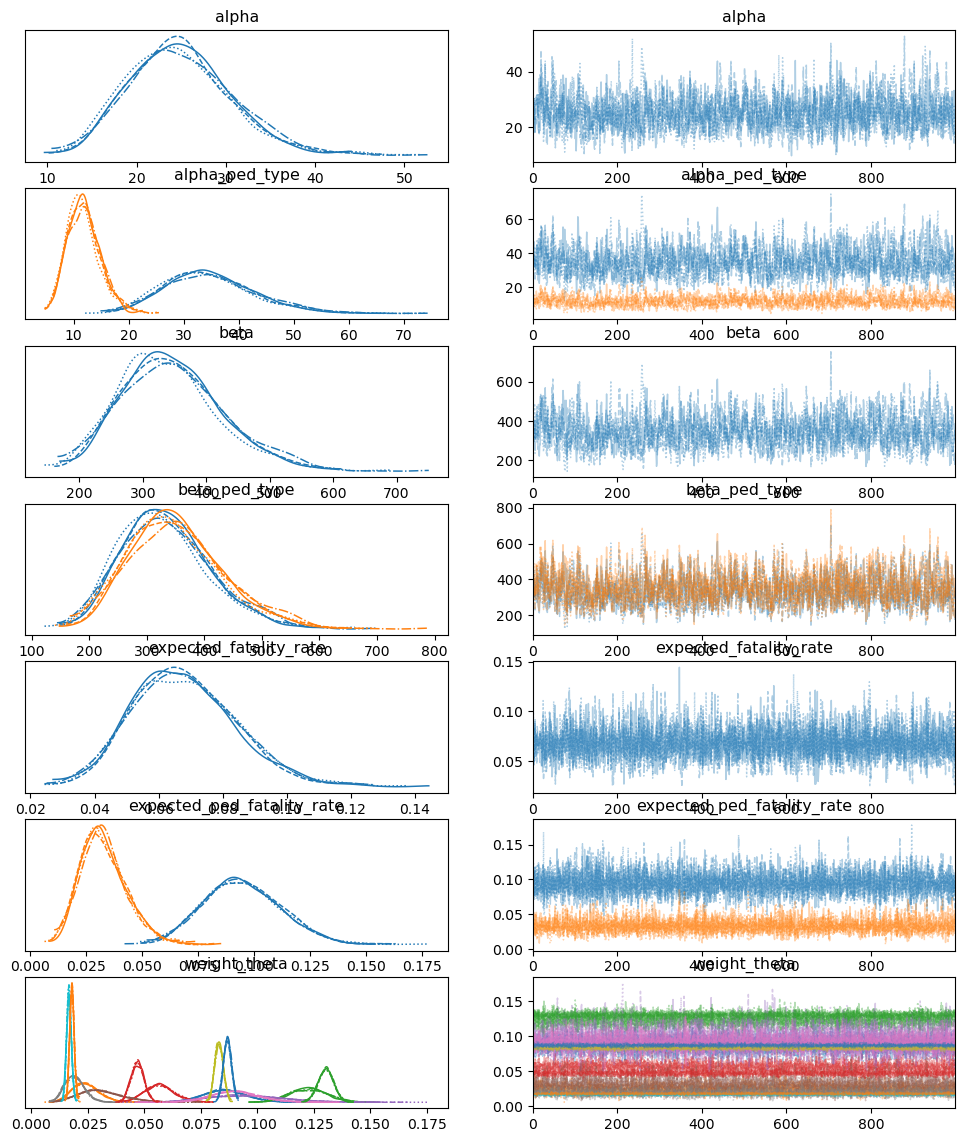

In [15]:
# all_samples = sampler.get_samples()
coords = {
    "ped_type": ["Pedestrian", "Cyclist"],
    "weight_class": encoder.categories_[0],
}
dims = {
    "weight_theta": ["weight_class", "ped_type"],
    "expected_weight_fatality_rate": ["weight_class", "ped_type"],
    "expected_ped_fatality_rate": ["ped_type"],
}
trace = az.from_numpyro(sampler, coords=coords, dims=dims)
az.plot_trace(trace)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

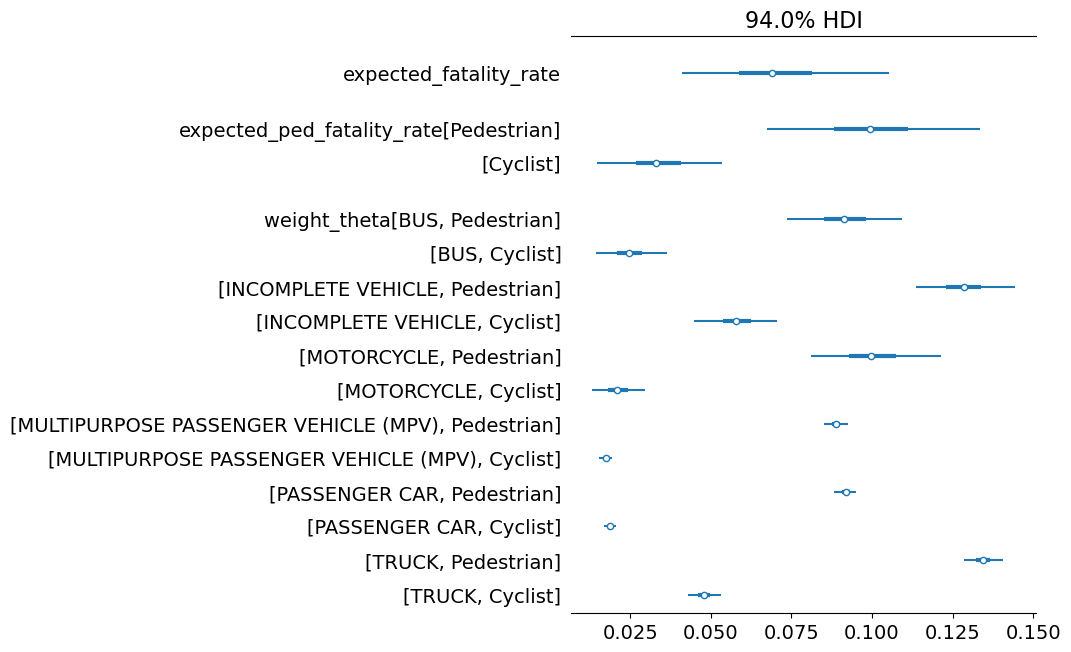

In [26]:
az.plot_forest(trace, combined=True, var_names=["expected_fatality_rate", "expected_ped_fatality_rate", "weight_theta"])